In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 3.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=2180feacd6903cbf7147708514c718a5281e6cde0672a6a6c676c8d8a740f903
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import yfinance as yf
import os
import matplotlib.patches as mpatches
import random

Code outline: \
1) Download data: write a function to do it **(DONE)**\
2) Write function to calculate exceedance correlation and all other functions necessary for the calculation **(DONE)**\
3) Calculate returns (log returns)**(DONE)**\
4) Plot the prices of all assets of interst\
5) Calculate the exceedance correlations among assets of interest **(DONE)**\
6) Plot the correlations (Be aware that there will be a lot of graphs to display pairwise relations)**(DONE)**\
7) Estimate ARMA-GARCH (use a simple model ARMA(1,1)-GARCH(1,1))\
8) Extract residuals and conditional variances to calculate standard residuals\
9) Calculate exceedance corr among standardized residuals\

In [ ]:
# Description: I want to input a list of tickers, the function needs to request 
# data from yahoo finance and store adj close price to a single data frame with col names being the tickers. 
def data_extractor(ticker_list, start_date, end_date):
  data_holder=pd.DataFrame()
  for i in ticker_list:
    stock_data = yf.download(i, start_date, end_date, progress=False)
    data_holder[i] = stock_data['Adj Close']
  return data_holder

In [ ]:
def exceedance_corr(X, Y, qc, indic): 
  T = len(X)
  k = len(qc)
  if indic ==1: 
    out1 = np.ones((2*k,1))*(-999.99)
  
  # Make sure enough data is available for further calculations: 
  # ---------Beginning of code to check data ---------
  qc2=qc
  for i in range(len(qc)):
    temp1 = np.count_nonzero(((X<=np.quantile(X,1-qc[i])).astype(int)*(Y<=np.quantile(Y,1-qc[i])).astype(int)).astype(int))
    temp2 = np.count_nonzero(((X>=np.quantile(X,qc[i])).astype(int)*(Y>=np.quantile(Y,qc[i])).astype(int)).astype(int))
    if ((temp1<3)+(temp2<3))>0: #if true, there is not enough data to compute a correlation in at least one tail. 
      qc2=np.setdiff1d(qc2,qc(i))
  # -------end of the check ---------
  qc_array=np.array(qc)
  qc_full=np.unique([qc_array, (1-qc_array)])

  
  for i in range(k):
    #df_index=res1_df[res1_df<=res1_df.quantile(0.3, axis=0, numeric_only=True, interpolation='linear')].dropna().index
    temp1 = (X[X<=X.quantile((1-qc[i]), interpolation='linear')]*Y[Y<=Y.quantile((1-qc[i]), interpolation='linear')]).dropna().index
    temp2 = (X[X<=X.quantile(qc[i],  interpolation='linear')]*Y[Y<=Y.quantile(qc[i],  interpolation='linear')]).dropna().index
    #out1(jj,1) = corrcoef12(X(temp1),Y(temp1))
    # x.corr(y)
    out1[k,0] = (X.loc[temp1]).corr(Y.loc[temp1])
    out1[9-k,0] = (X.loc[temp2]).corr(Y.loc[temp2])

  return out1


In [ ]:
def exceedance_corr2(X, Y, qc):
  corr_out = []
  k = len(qc)
  for i in range(k):
    if qc[i]<0.5:
      temp = (X[X<=X.quantile(qc[i], interpolation='linear')]*Y[Y<=Y.quantile(qc[i], interpolation='linear')]).dropna().index
      corr_coef = (X.loc[temp]).corr(Y.loc[temp])
      corr_out.append(corr_coef)
    else:
      temp = (X[X>=X.quantile(qc[i], interpolation='linear')]*Y[Y>=Y.quantile(qc[i], interpolation='linear')]).dropna().index
      corr_coef = (X.loc[temp]).corr(Y.loc[temp])
      corr_out.append(corr_coef)

  return corr_out

In [ ]:
qc=[0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

In [ ]:
# Function to calculate log returns in df: 
def df_log_return(data, ticker_list):
  for i in ticker_list: 
    data[i+'_log_return'] = np.log1p(data[i].pct_change())
  return data


In [ ]:
def plot_exceedance_corr(data, ticker_list, qc):
  matrix_size=len(ticker_list)
  fig, axs = plt.subplots(matrix_size, matrix_size)
  fig.set_size_inches(20, 14) 
  custom_ylim = (-1, 1)
  plt.setp(axs,  ylim=custom_ylim)
  for ii in range(matrix_size):
    for jj in range(matrix_size):
      tp_1 = ticker_list[ii]
      tp_2 = ticker_list[jj]
      dp_1 = data[tp_1+'_log_return']
      dp_2 = data[tp_2+'_log_return']
      axs[ii,jj].plot(qc, exceedance_corr2(dp_1,dp_2, qc))
      axs[ii,jj].set_title(tp_1+' vs '+tp_2)


### Different Asset Classes:
Equity (SPY) vs Treasuries (TLT) vs Gold (GLD) vs Commodities (DBC) vs Vol (VXX) vs Crypto (BTC-USD)

In [ ]:
# Define data for downloading:
tickers = ['SPY', 'TLT', 'GLD', 'DBC', '^VIX', 'BTC-USD']
start_date = '2011-01-01'
end_date = '2021-05-21'

In [ ]:
# Download the data: 
asset_class_data = data_extractor(tickers, start_date, end_date)

In [ ]:
# Calculate log returns: 
log_return_df=df_log_return(asset_class_data,tickers)

In [ ]:
log_return_df.head()

,SPY,TLT,GLD,DBC,^VIX,BTC-USD,SPY_log_return,TLT_log_return,GLD_log_return,DBC_log_return,^VIX_log_return,BTC-USD_log_return
Date,,,,,,,,,,,,
2011-01-03,103.779396,71.509758,138.000000,26.884541,17.610001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,103.722198,71.594009,134.750000,26.525042,17.379999,NaN,-0.000551,0.001177,-0.023832,-0.013462,-0.013147,NaN
2011-01-05,104.261322,70.016983,134.369995,26.806808,17.020000,NaN,0.005184,-0.022274,-0.002824,0.010567,-0.020931,NaN
2011-01-06,104.057114,70.323196,133.830002,26.447313,17.400000,NaN,-0.001961,0.004364,-0.004027,-0.013501,0.022081,NaN
2011-01-07,103.852882,70.698265,133.580002,26.350153,17.139999,NaN,-0.001965,0.005319,-0.001870,-0.003680,-0.015055,NaN


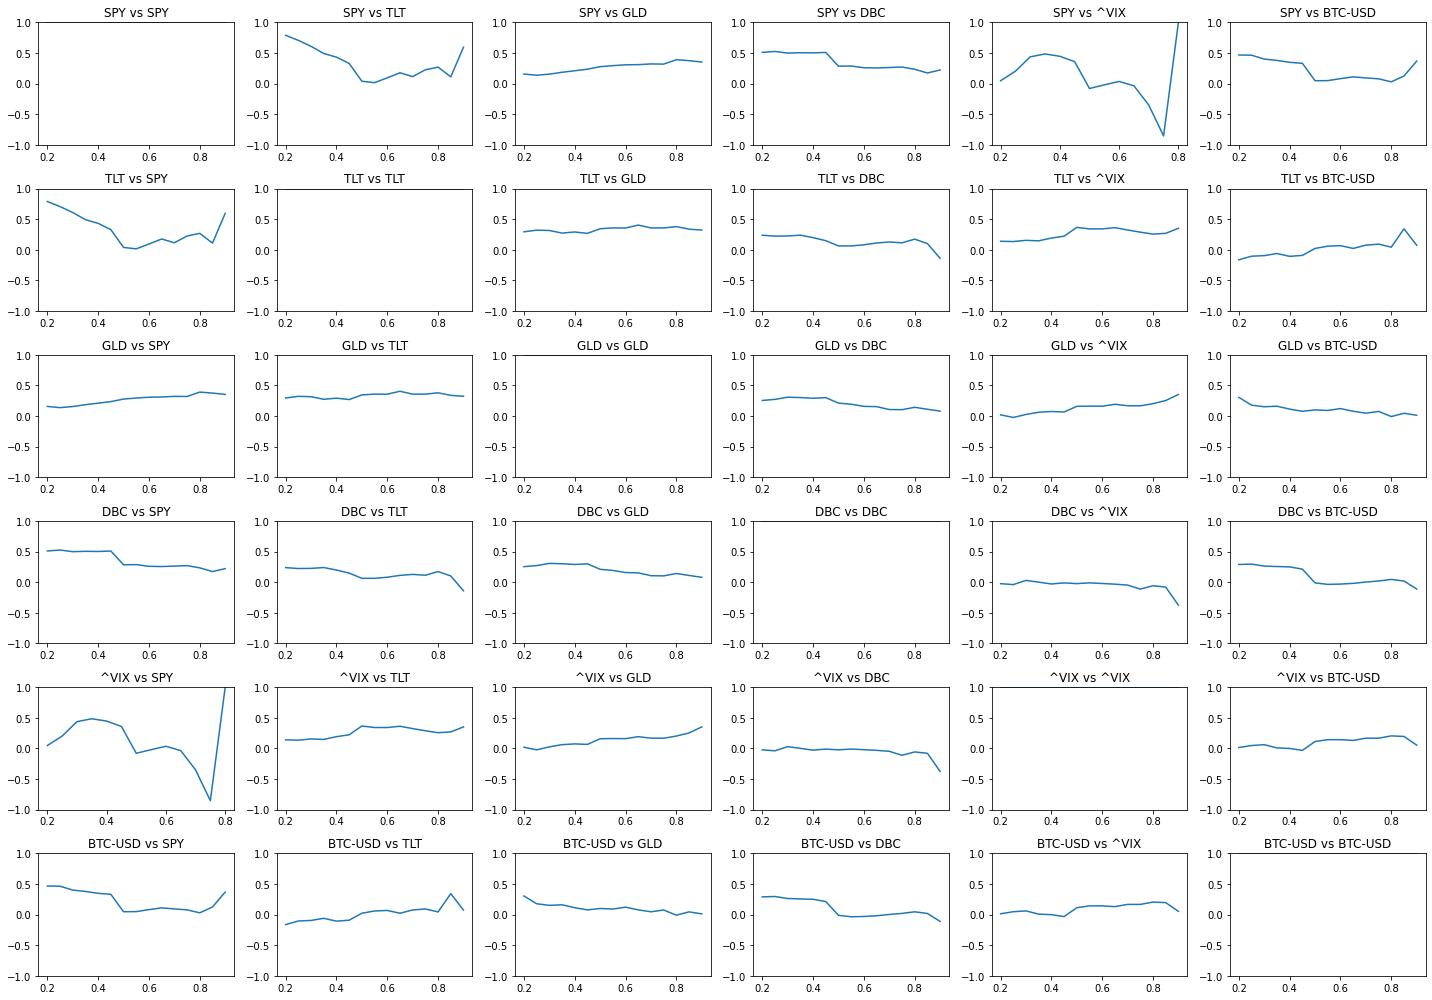

In [ ]:
# plot price for each asset class: 
plot_exceedance_corr(log_return_df, tickers, qc)
plt.tight_layout()


### Different countries: 
US (SPY)
China (MCHI)
Germany (EWG)
India (INDA)
Australia (EWA)
Canada (EWC)
Brazil (EWZ)


In [ ]:
# Define data for downloading:
country_tickers = ['SPY', 'MCHI', 'EWG', 'INDA', 'EWA', 'EWC', 'EWZ']
start_date = '2011-01-01'
end_date = '2021-05-21'
# Download the data: 
country_data = data_extractor(country_tickers, start_date, end_date)
# Calculate log returns: 
country_log_return_df=df_log_return(country_data,country_tickers)

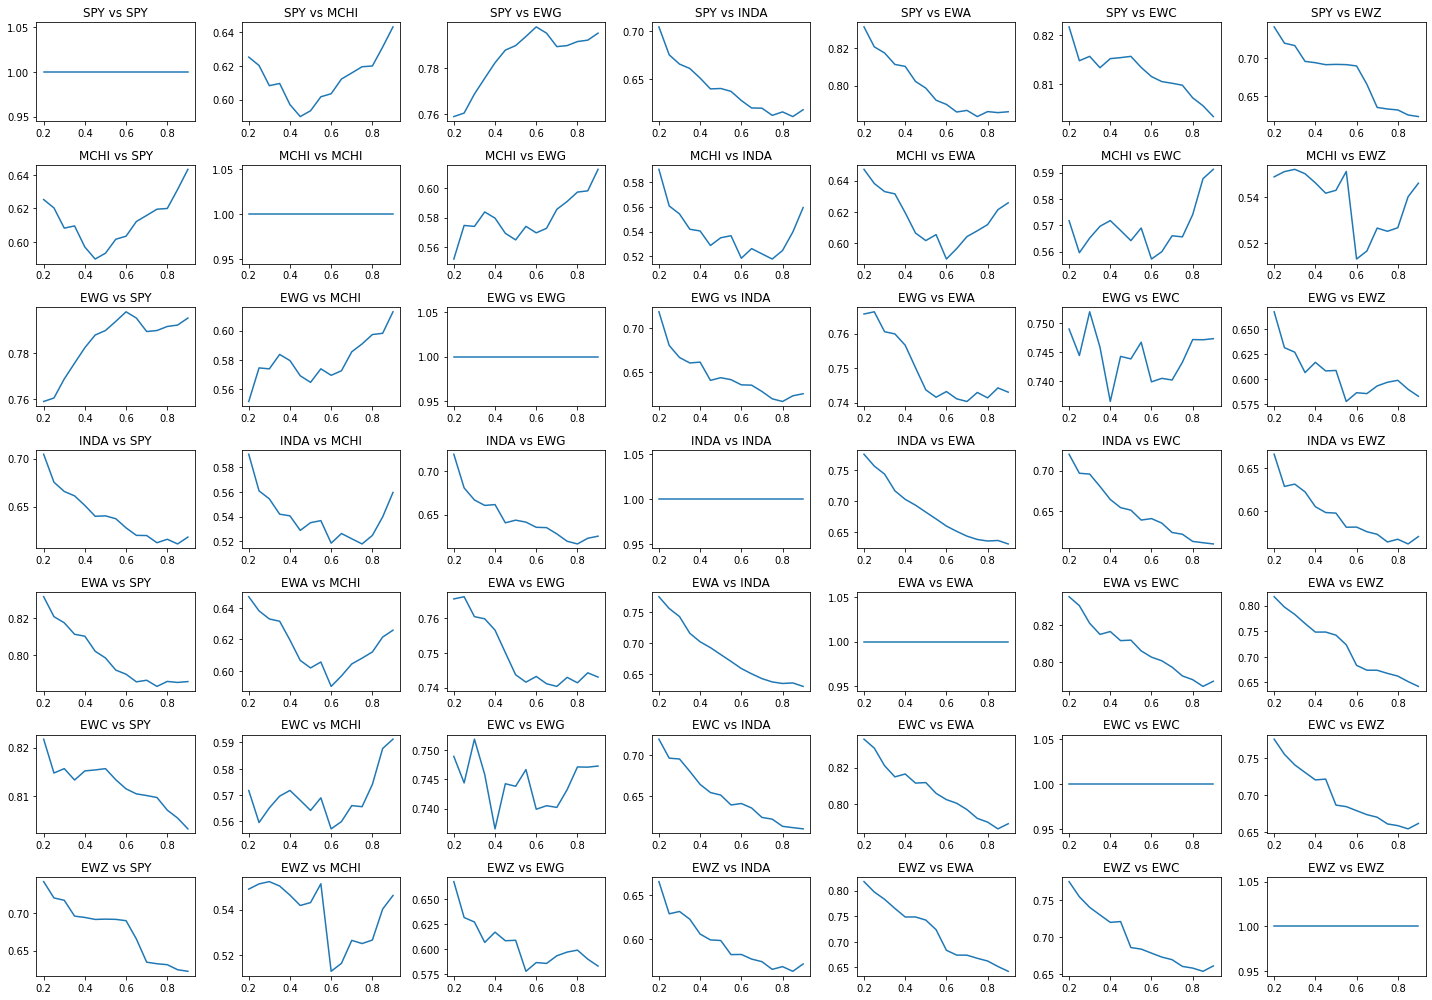

In [ ]:
# plot price for each asset class: 
plot_exceedance_corr(country_log_return_df, country_tickers, qc)
plt.tight_layout()

### Sectors exceedance corr:
Consumer discretionary(XLY)
Financials (XLF)
Health Care (XLV)
Tech (XLK)
Consumer Staples(XLP)
Industrials (XLI)
Materials(XLB)
Energy (XLE)
Utilities (XLU)
RE (XLRE)
Communications (XLC)

In [ ]:
# Define data for downloading:
sector_tickers = ['XLY', 'XLF', 'XLV', 'XLK', 'XLP', 'XLI', 'XLB', 'XLE', 'XLU', 'XLRE', 'XLC']
start_date = '2011-01-01'
end_date = '2021-05-21'
# Download the data: 
sector_data = data_extractor(sector_tickers, start_date, end_date)
# Calculate log returns: 
sector_log_return_df=df_log_return(sector_data,sector_tickers)


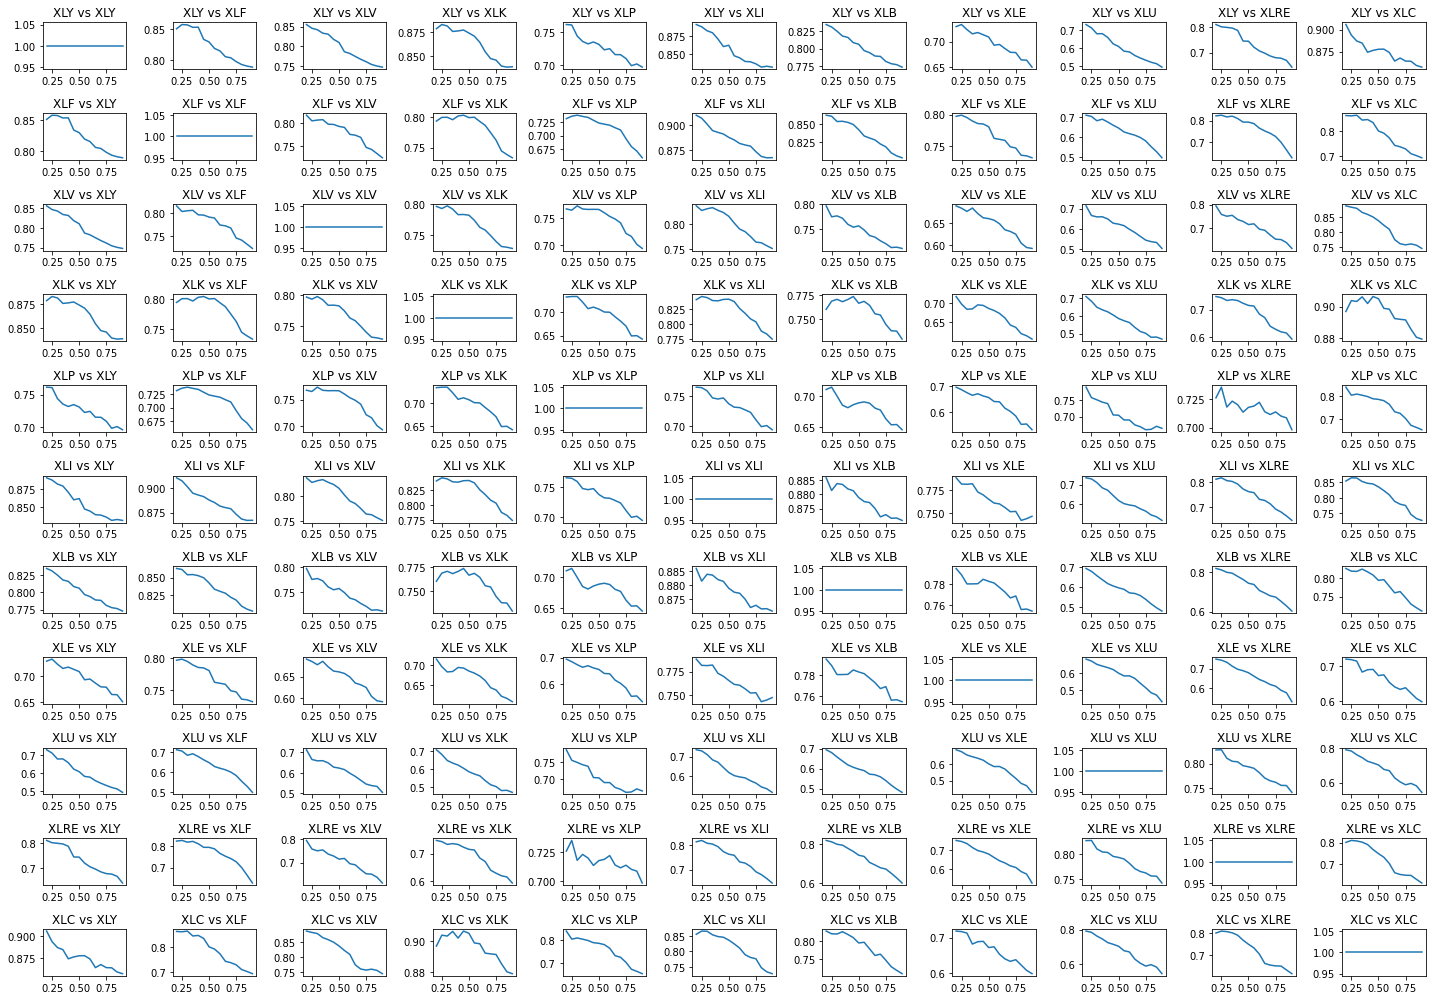

In [ ]:
# plot price for each sector: 
plot_exceedance_corr(sector_log_return_df, sector_tickers, qc)
plt.tight_layout()

### Other


In [ ]:
# Let's try the code: 
symbol_1 = 'GLD' 
symbol_2 = '^GSPC'
start_date = '2005-01-01'
end_date = '2021-05-21'
gld_px=yf.download(symbol_1, start_date, end_date, progress=False)
sp500_px=yf.download(symbol_2, start_date, end_date, progress=False)

In [ ]:
gld_px_adj = gld_px['Adj Close']
sp500_px_adj = sp500_px['Adj Close']

# np.diff(np.log(df.price))
gld_px['gld_log_return']= np.log1p(gld_px_adj.pct_change())
sp500_px['sp500_log_return'] = np.log1p(sp500_px_adj.pct_change())

In [ ]:
gld_sp500_corr = exceedance_corr(gld_px['gld_log_return'],sp500_px['sp500_log_return'], qc)

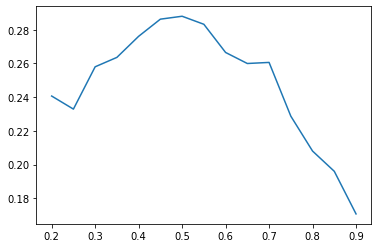

In [ ]:
plt.plot(qc, gld_sp500_corr)

In [ ]:
i = 'VDA'

In [ ]:
i+'4'

'VDA4'